<a href="https://colab.research.google.com/github/kevindmzapata/deep-learning-project/blob/main/04_red_neuronal_convolucional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 - Estimación de la OSNR usando un Modelo de Red Neuronal Convolucional (CNN)

## I. Importar las librerias necesarias

In [1]:
!wget -nc --no-cache -O database.zip -q https://raw.githubusercontent.com/kevindmzapata/deep-learning-project/main/database.zip
!unzip -n -q database.zip
!rm database.zip
!wget -nc --no-cache -O utils.py -q https://raw.githubusercontent.com/kevindmzapata/deep-learning-project/main/resources/utils.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, Conv2D, Flatten
from utils import load_data

In [3]:
images, labels, ch_spacing = load_data('database')

In [4]:
print("Las dimensiones de la base de datos son: ", images.shape, labels.shape, ch_spacing.shape)

Las dimensiones de la base de datos son:  (729, 32, 32) (729,) (729,)


## II. Remodelación de los datos

In [5]:
X = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1) / 255.0
y = labels.reshape(labels.shape[0], 1)
ch = np.eye(len(np.unique(ch_spacing)))[ch_spacing]

In [6]:
print('Las imagenes estan en un rango de', X.min(), 'a', X.max())

Las imagenes estan en un rango de 0.0 a 1.0


In [7]:
print('Las etiquetas estan en un rango de', y.min(), 'a', y.max())

Las etiquetas estan en un rango de 18.0 a 40.0


In [8]:
print('La información adicional de espaciamiento de canal es de la forma de', ch.shape)

La información adicional de espaciamiento de canal es de la forma de (729, 8)


In [9]:
print(ch[:5]) # One Hot Encoding

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


## III. Generar modelo de CNN

In [10]:
def create_model(input_dim, output_dim, extra_feat_dim=None, activation='relu'):
    input_0 = Input(shape=(input_dim, input_dim, 1))
    x = Conv2D(filters=4, kernel_size=(3, 3), strides=(2, 2), activation=activation, padding='same')(input_0)
    x = Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), activation=activation, padding='same')(x)
    x = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), activation=activation, padding='same')(x)
    x = Flatten()(x)
    inputs = [input_0]

    if extra_feat_dim is not None:
        input_1 = Input(shape=(extra_feat_dim,))
        x = concatenate([x, input_1])
        inputs = [input_0, input_1]

    x = Dense(units=200, activation=activation)(x)
    output = Dense(units=1)(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mae', optimizer='adam')
    return model

In [11]:
create_model(X.shape[1], y.shape[1], extra_feat_dim=ch.shape[1]).summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 4)      │             40 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 8)        │            296 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 16)       │          1,168 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 256)            │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 264)            │              0 │ flatten[0][0],         │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 200)            │         53,000 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            201 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 54,705 (213.69 KB)

 Trainable params: 54,705 (213.69 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_scores = []
kf_histories = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ch_train, ch_test = ch[train_index], ch[test_index]

    scaler = MinMaxScaler(feature_range=(0, 1)).fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)

    model = create_model(X.shape[1], y.shape[1], extra_feat_dim=ch.shape[1])
    history = model.fit([X_train, ch_train], y_train, epochs=500, batch_size=16,
                        validation_data=([X_test, ch_test], y_test), verbose=0)
    kf_histories.append(history)

    y_pred = model.predict([X_test, ch_test])
    preds = scaler.inverse_transform(y_pred)
    y_true = scaler.inverse_transform(y_test)
    mae = mean_absolute_error(y_true, preds)
    kf_scores.append(mae)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [15]:
print(f'El MAE es: {np.mean(kf_scores):.4f} dB')
#

El MAE es: 0.9239 dB


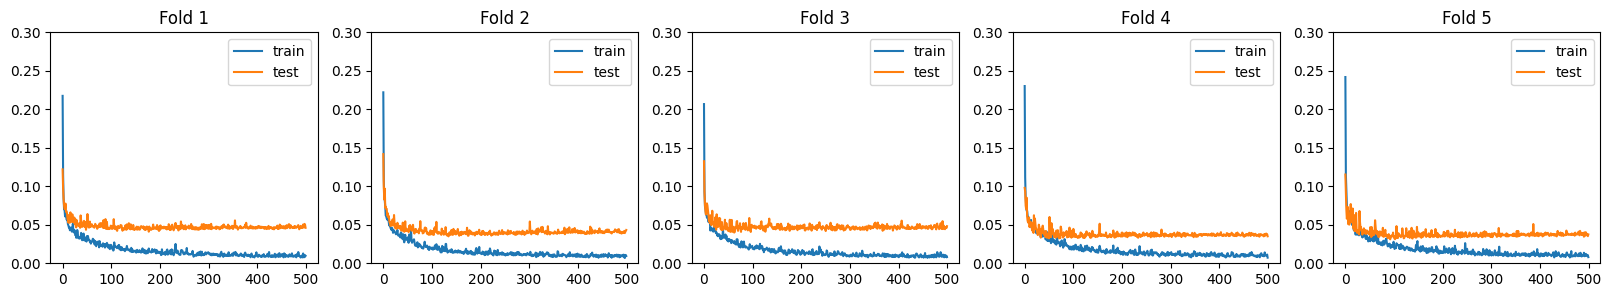

In [16]:
plt.figure(figsize=(20, 3))

for i in range(len(kf_histories)):
    plt.subplot(1, 5, i+1)
    plt.plot(kf_histories[i].history['loss'], label='train')
    plt.plot(kf_histories[i].history['val_loss'], label='test')
    plt.ylim([0, 0.3])
    plt.title('Fold ' + str(i+1))
    plt.legend()
plt.show()